In [1]:
import sys
import time
import warnings
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import rand
from multiprocess import Pool
plt.style.use('seaborn-poster')
line = '========================================================================================'

In [2]:
# stocastic function
def Pr(h): return 1 if np.random.rand() <  np.exp(h/T) / (np.exp(h/T)+np.exp(-h/T)) else -1

# weight matrix
def weightMatrix(Xi):
    N = len(Xi[0])
    J = np.zeros((N, N))
    for i in range(N):
        for j in range(i+1, N, 1):
            J[i][j] = np.dot(Xi[:,i],Xi[:,j])
            J[j][i] = J[i][j]
            
    return J/N

In [25]:
# function
def singleMemoryOverlap (Xi):
    '''Solve for a single initial memory Xi'''
    
    # Parameters
    # ----------
    # 
    #     Xi : ndarray
    #       Initial memory array
    #
    #
    # Return
    # ------
    #     m : float
    #       Overlap value
    #
    #     k : int
    #       Number of metwork loops
    #
    np.random.seed()
    
    # pointer to weights matrix
    global J
    
    # number of neurons
    N  = len(Xi)
    
    # Estado de la red a tiempo 0
    s = [i for i in Xi]

    k = 0
    # Update sites one by one
    while True:
        k +=1
        # previews state
        previews = [i for i in s]

        # iterate over all points in the network
        for index in range(N): s[index] = 1 if np.dot(J[index], s) >0 else -1
           
        # condition to stop: previews state equal to current state 
        if s==previews: break

        # warning for convergency problems
        if k>200: warnings.warn('The network did not converged'); break
    
    print('.', end='')
    sys.stdout.flush()
    
    # return overlap, number of completed loops around the network
    return (1./N) * np.dot(Xi, s), k
    
# function    
def networkOverlap(N, alpha):
    ''' Solve for all initial memories Xi'''
    
    # Parameters
    # ----------
    # 
    #     N : integer
    #       Number of neurons
    #     
    #     alpha : float
    #       Number of neurons to memories number ratio
    #
    # Return
    # ------
    #     m : ndarray
    #       Overlap array
    #
    
    # Declare global weight matrix
    global J
    
    # number of memories
    p = int(N*alpha)

    # Patrones
    Xi = np.array([[1 if rand()>0.5 else -1 for n in range(N)] for i in range(p)])
    
    # weights Matrix
    J = weightMatrix(Xi)
    
    # number of workers
    p = Pool(7)
    
    # run
    print('RUNING:')
    result = p.map_async(singleMemoryOverlap, Xi )
    
    # close pool
    p.close()
    p.join()
    
    return result.get()

# run
data3 = []
totalTime = time.time()
for N in [500, 1000, 2000, 4000]:
    for alpha in [0.12, 0.14, 0.16, 0.18]:
        start = time.time()
        print('(%d - %.2f)' %(N, alpha))
        data3.append(networkOverlap(N, alpha))
        print('\ntime: %.0f seconds' %(time.time()-start))
        print('Iterations: %.0f' %(np.mean([m[1] for m in data3[-1]])))
        print(line)

# extract overlaps
overlap3 = [[innerData[0] for innerData in outerData] for outerData in data3]

# print total time
print('analysis time: %.0f' %(time.time()-totalTime))

(500 - 0.12)
.................RUNING:
...........................................
time: 1 seconds
Iterations: 2
(500 - 0.14)
.............RUNING:
.........................................................
time: 2 seconds
Iterations: 3
(500 - 0.16)
.......RUNING:
.........................................................................
time: 4 seconds
Iterations: 8
(500 - 0.18)
....RUNING:
......................................................................................
time: 5 seconds
Iterations: 9
(1000 - 0.12)
..RUNING:
......................................................................................................................
time: 7 seconds
Iterations: 2
(1000 - 0.14)
RUNING:
............................................................................................................................................
time: 16 seconds
Iterations: 5
(1000 - 0.16)
RUNING:
.......................................................................................................

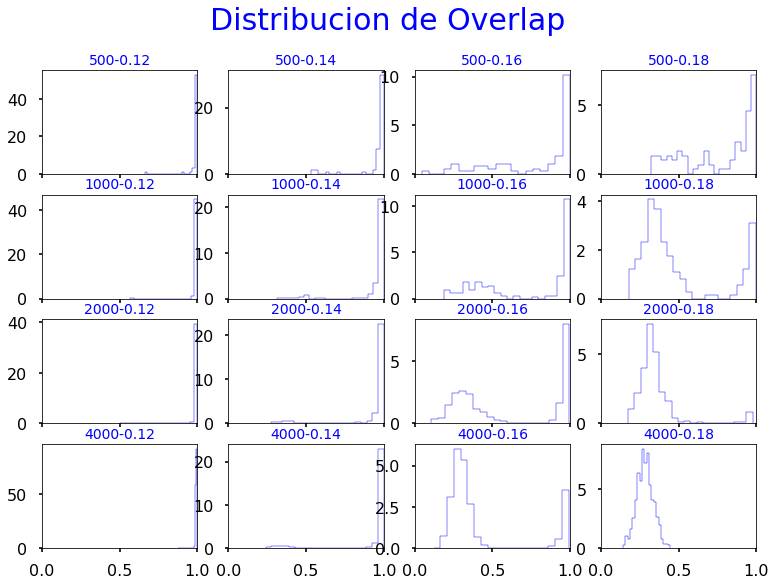

In [26]:
# plot density
fig, ax = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=False)
for i, N in enumerate([500, 1000, 2000, 4000]):
    for j, alpha in enumerate([0.12, 0.14, 0.16, 0.18]):
        text=str(N)+'-'+str(alpha)
        ax[i][j].hist(overlap3[i*4+j], bins=20 ,density=True, histtype='step', rwidth=0.85, color='b')
        ax[i][j].set_title(label=text, color='blue', fontsize=14)
        ax[i][j].set_xlim([0, 1])
fig.suptitle('Distribucion de Overlap',color='blue', fontsize=30)

plt.show()

In [5]:
# function
def singleMemoryStocasticOverlap(Xi):
    '''Solver for a single initial memory Xi'''
    
    # Parameters
    # ----------
    # 
    #     Xi : ndarray
    #       Initial memory array.
    #
    # Return
    # ------
    #     m : float
    #       Overlap value.
    #
    
    global J, T, loops
    
    # number of neurons
    N  = len(Xi)
    
    # Estado de la red a tiempo 0
    s = [i for i in Xi]
    
    # Update sites one by one
    for loop in range(loops): 
        for i in range(N): s[i] = Pr(np.dot(J[i], s))
    
    # return overlap
    return 1./N*np.dot(Xi,s)

# function
def networkStocasticOverlap(Xi):
    global J, T, loops
    
    start = time.time()
    print('(Temperature: %.2f)' %(T))
    
    # number of workers
    p = Pool(7)
    
    # run
    print('RUNING:')
    result = p.map_async(singleMemoryStocasticOverlap, Xi )
    
    # close pool
    p.close()
    p.join()
    
    print('\ntime: %.0f seconds' %(time.time()-start))
    print(line)
    
    return result.get()
    
# parametros
p = 40; N = 4000; loops = 10 ; temp = np.arange(0.1, 2, 0.1)

# Patrones
Xi = np.array([[1 if rand()>0.5 else -1 for n in range(N)] for i in range(p)])
    
# weights Matrix
J = weightMatrix(Xi)

# run
data2 = []
totalTime = time.time()

for T in temp: data2.append(networkStocasticOverlap(Xi))

# extract overlaps
overlap2 = np.array([[np.mean(dat), np.var(dat)] for dat in data2])

# print total time
print('analysis time: %.0f' %(time.time()-totalTime))

(Temperature: 0.10)
RUNING:

time: 145 seconds
(Temperature: 0.20)
RUNING:

time: 144 seconds
(Temperature: 0.30)
RUNING:

time: 143 seconds
(Temperature: 0.40)
RUNING:

time: 142 seconds
(Temperature: 0.50)
RUNING:

time: 145 seconds
(Temperature: 0.60)
RUNING:

time: 141 seconds
(Temperature: 0.70)
RUNING:

time: 144 seconds
(Temperature: 0.80)
RUNING:

time: 145 seconds
(Temperature: 0.90)
RUNING:

time: 142 seconds
(Temperature: 1.00)
RUNING:

time: 145 seconds
(Temperature: 1.10)
RUNING:

time: 146 seconds
(Temperature: 1.20)
RUNING:

time: 144 seconds
(Temperature: 1.30)
RUNING:

time: 144 seconds
(Temperature: 1.40)
RUNING:

time: 143 seconds
(Temperature: 1.50)
RUNING:

time: 142 seconds
(Temperature: 1.60)
RUNING:

time: 143 seconds
(Temperature: 1.70)
RUNING:

time: 143 seconds
(Temperature: 1.80)
RUNING:

time: 142 seconds
(Temperature: 1.90)
RUNING:

time: 143 seconds
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1

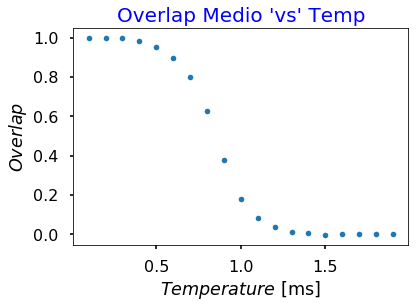

In [6]:
plt.title("Simplest errorbars, 0.2 in x, 0.4 in y")
plt.errorbar(temp, overlap2[:,0], yerr=overlap2[:,1], fmt='.')
plt.title(r"Overlap Medio 'vs' Temp", color='blue', fontsize=20)
plt.xlabel(r'$Temperature$ [ms]')
plt.ylabel(r'$Overlap$')
plt.show()